<a href="https://colab.research.google.com/github/nanoNNsk/superaiss5_hackathon/blob/main/superaiss5_hackathon_signal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

{}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c signal-fast-radio-burst-detection

100% 13.8G/13.9G [02:11<00:00, 220MB/s]
100% 13.9G/13.9G [02:12<00:00, 113MB/s]


In [5]:
!unzip signal-fast-radio-burst-detection.zip -d ./data/

Archive:  signal-fast-radio-burst-detection.zip
  inflating: ./data/sample_submission.csv  
  inflating: ./data/test/test/0.npy  
  inflating: ./data/test/test/1.npy  
  inflating: ./data/test/test/10.npy  
  inflating: ./data/test/test/11.npy  
  inflating: ./data/test/test/12.npy  
  inflating: ./data/test/test/13.npy  
  inflating: ./data/test/test/14.npy  
  inflating: ./data/test/test/15.npy  
  inflating: ./data/test/test/16.npy  
  inflating: ./data/test/test/17.npy  
  inflating: ./data/test/test/18.npy  
  inflating: ./data/test/test/19.npy  
  inflating: ./data/test/test/2.npy  
  inflating: ./data/test/test/20.npy  
  inflating: ./data/test/test/21.npy  
  inflating: ./data/test/test/22.npy  
  inflating: ./data/test/test/23.npy  
  inflating: ./data/test/test/24.npy  
  inflating: ./data/test/test/25.npy  
  inflating: ./data/test/test/26.npy  
  inflating: ./data/test/test/27.npy  
  inflating: ./data/test/test/28.npy  
  inflating: ./data/test/test/29.npy  
  inflating: .

In [1]:
# Let's Start by Importing packages
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
plt.rcParams['font.size'] = 16

# Newest Version of Pandas returns too much, warning, So I turned it off
pd.set_option("future.no_silent_downcasting", True)

In [2]:
# Here I set the path for Input Spectra and Label

Training_Set_Folder = "/content/data/train/train"

X_Training_Files = sorted(glob.glob(Training_Set_Folder + "/*.npy"))
Y_Training_Files = sorted(glob.glob(Training_Set_Folder + "/*.csv"))

# data inspection

In [3]:
# Let's Inspect Something by pick up the data for inspection
rec_num = 0
X_demo = np.load(X_Training_Files[rec_num])
Y_demo = pd.read_csv(Y_Training_Files[rec_num])
Y_demo["labels"].value_counts()

,count
labels,
Broad,80
Pulse,9
Broad+Pulse,2


In [4]:
Y_demo[Y_demo['labels'] == "Broad"]

,Unnamed: 0,index,labels
815,815,815,Broad
840,840,840,Broad
841,841,841,Broad
842,842,842,Broad
843,843,843,Broad
...,...,...,...
916,916,916,Broad
917,917,917,Broad
918,918,918,Broad
919,919,919,Broad


# Try use data to plot

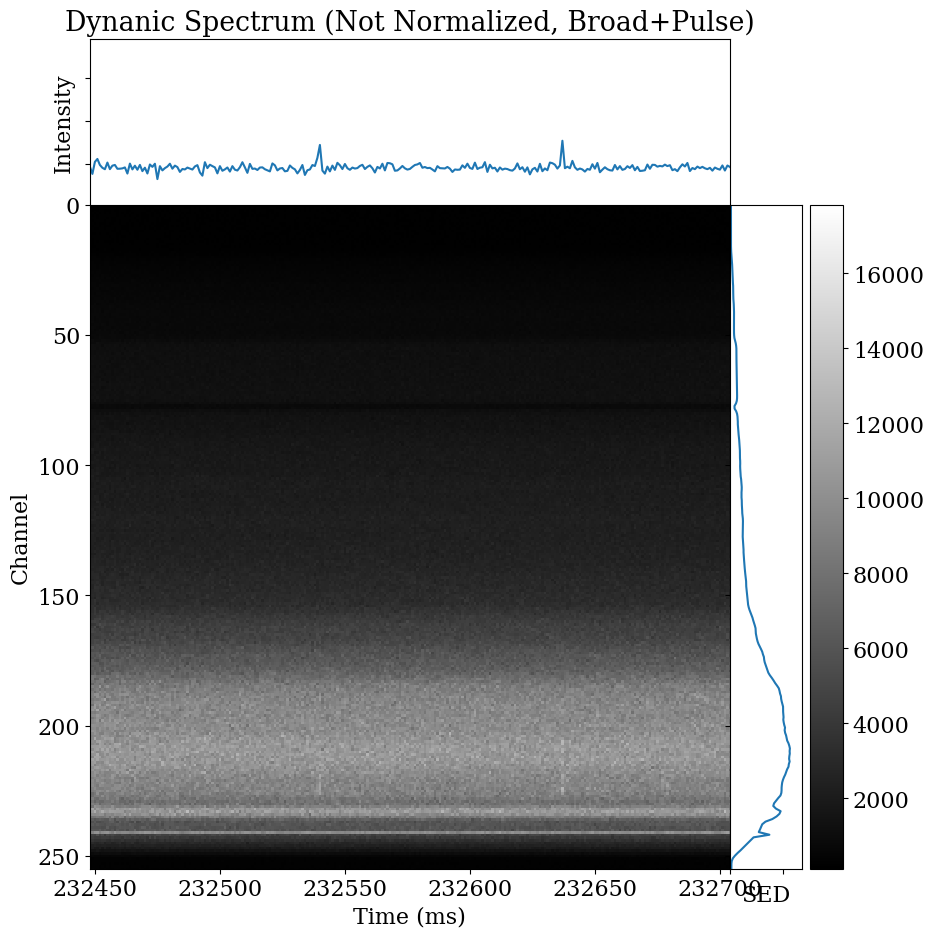

In [5]:
def make_plot(X_demo, title_string=None, peak = None, vmin=None, vmax=None):
    fig = plt.figure(figsize=(10,10))
    gs = fig.add_gridspec(2, 2, width_ratios=(4, 1), height_ratios=(1, 4),
                            left=0.1, right=0.9, bottom=0.1, top=0.93,
                            wspace=0, hspace=0)

    dynanic_spectrum = np.transpose(X_demo)

    ax1 = fig.add_subplot(gs[1, 0])
    heatmap = ax1.imshow(dynanic_spectrum,aspect="auto", origin='upper', interpolation="none", cmap="gray",vmin=vmin,vmax=vmax)
    ax1.set_xlabel("Time (ms)")
    ax1.set_ylabel("Channel")
    ax1.set_ylim(dynanic_spectrum.shape[0]-1,0)

    if peak is not False:
        if peak is None:
            peak = np.argmax(np.sum(dynanic_spectrum,axis=0))
        else:
            peak = peak * 256
        offset = 256
        ax1.set_xlim(peak, peak+offset)

    ax2 = fig.add_subplot(gs[1, 1])
    powerspectrum = np.sum(dynanic_spectrum,axis=1)
    freq_bin = np.linspace(0,len(powerspectrum),len(powerspectrum))
    plt.plot(powerspectrum, freq_bin)
    ax2.set_yticklabels([])
    ax2.set_xticklabels([])
    ax2.set_xlim(0, 1.2 * np.max(powerspectrum))
    ax2.set_ylim(ax1.get_ylim())
    ax2.set_xlabel("SED")


    ax3 = fig.add_subplot(gs[0, 0])
    lightcurve = np.sum(dynanic_spectrum,axis=0)
    ax3.plot(lightcurve)
    ax3.set_xlim(ax1.get_xlim())
    ax3.set_xticklabels([])
    ax3.set_yticklabels([])
    #ax3.set_ylim(0, 1.2 * np.max(lightcurve))
    ax3.set_ylabel(r"Intensity")
    if title_string is not None:
        ax3.set_title(title_string)

    fig.colorbar(heatmap, ax=ax2, orientation="vertical",fraction = .5)
    plt.show()

make_plot(X_demo, title_string="Dynanic Spectrum (Not Normalized, Broad+Pulse)", peak=908)

# normalized spectrum

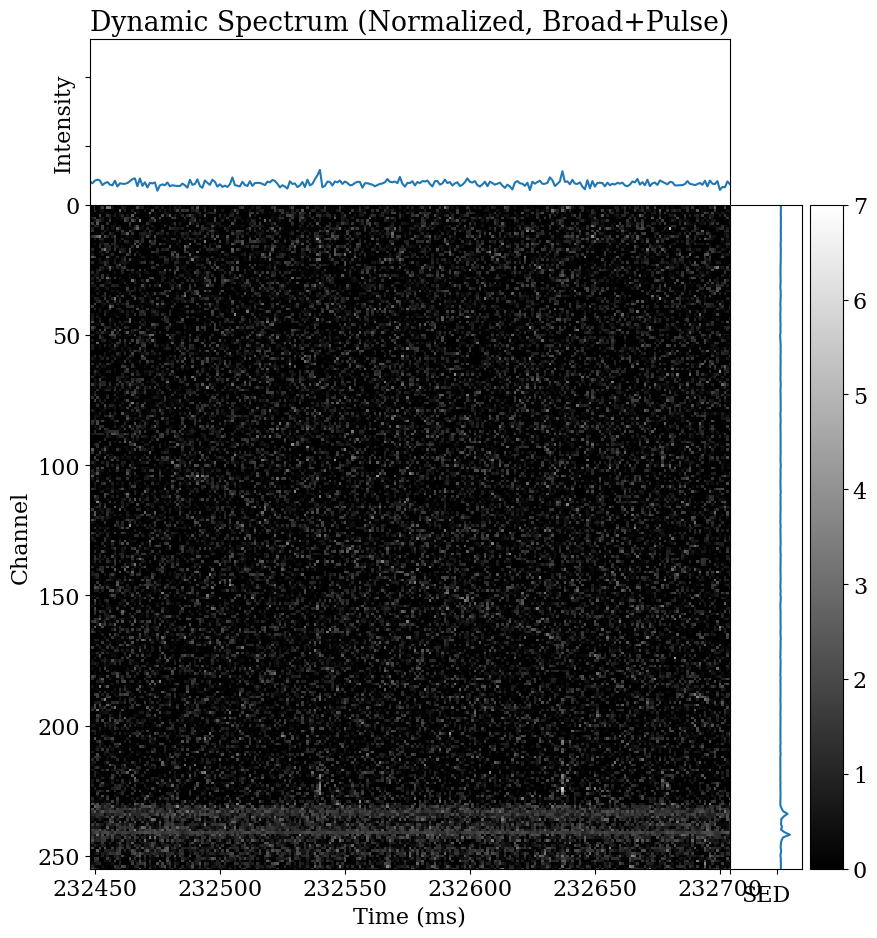

In [6]:
def snr_normalized(X_demo):
    Dynamic_spectrum = np.transpose(X_demo)
    med = np.median(Dynamic_spectrum, axis=1)
    stdev = np.std(Dynamic_spectrum, axis=1)
    normalized_Dynamic_spectrum = (Dynamic_spectrum.T - med) / stdev
    normalized_Dynamic_spectrum[normalized_Dynamic_spectrum < 0] = 0
    return normalized_Dynamic_spectrum

normalized_Dynamic_spectrum = snr_normalized(X_demo)

make_plot(normalized_Dynamic_spectrum, title_string="Dynamic Spectrum (Normalized, Broad+Pulse)",peak=908,vmin=0, vmax=7)

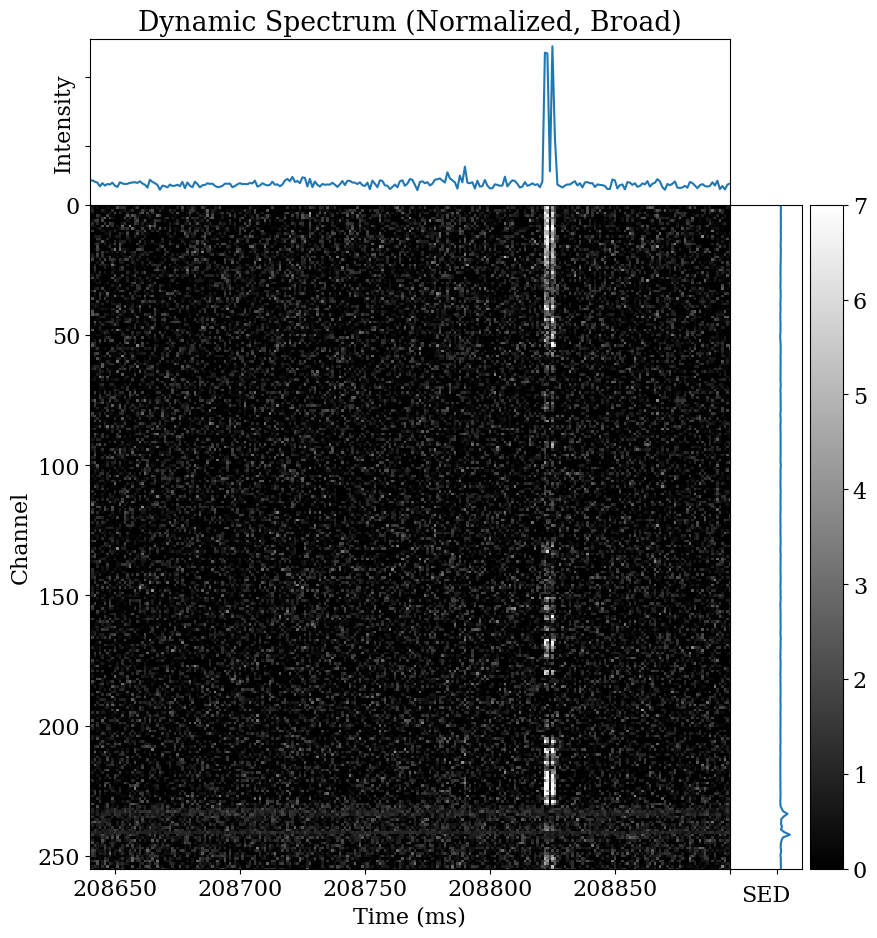

In [7]:
make_plot(normalized_Dynamic_spectrum, title_string="Dynamic Spectrum (Normalized, Broad)",peak=815, vmin=0, vmax=7)

# Check data

In [8]:
test_data = np.load("/content/data/test/test/0.npy")
print(test_data)

[[168.18799 159.41458 190.99876 ... 262.0382  240.94456 305.77786]
 [156.46451 212.44066 193.00768 ... 271.91284 271.5047  248.10605]
 [185.41689 208.41719 210.58577 ... 235.50969 241.02974 277.64148]
 ...
 [182.33984 180.54425 168.82347 ... 234.22046 234.64804 289.80048]
 [171.88824 182.28685 217.5126  ... 254.04341 249.72957 322.95126]
 [180.71529 150.35742 200.15329 ... 242.37332 241.48944 264.06296]]


In [9]:
Y_demo[Y_demo['labels'] == "Broad"]

,Unnamed: 0,index,labels
815,815,815,Broad
840,840,840,Broad
841,841,841,Broad
842,842,842,Broad
843,843,843,Broad
...,...,...,...
916,916,916,Broad
917,917,917,Broad
918,918,918,Broad
919,919,919,Broad


# Check Label

In [10]:
all_counts = pd.Series(dtype=int)
for file in Y_Training_Files:
    Y_demo = pd.read_csv(file)
    counts = Y_demo["labels"].value_counts()
    all_counts = all_counts.add(counts, fill_value=0)
all_counts = all_counts.astype(int)
print(all_counts)

labels
Broad             3201
Broad+Pulse          9
Narrow            8582
Narrow+Broad       138
Narrow+Pulse        60
Pulse             3847
Uncertain         5721
Unknown+Pulse       37
Unlabeled        28065
dtype: int64


In [11]:
# Here, we load the target file and replace their labels with class number
Label = []
pop_list = []
for i in tqdm(range(0,len(Y_Training_Files))):
    rec = pd.read_csv(Y_Training_Files[i])
    if len(rec) == 1024:
        labels = rec["labels"].replace(to_replace={np.nan: 0, "Unlabeled":0, "Uncertain":0, "Narrow+Broad":0,"Unknown":0,
                                                    "Pulse": 1,"Unknown+Pulse":1, "Broad+Pulse": 1, "Narrow+Pulse":1,
                                                    "Broad": 2, "Narrow":3}).to_numpy()
        Label.append(labels)
    else:
       pop_list.append(i)

Label = np.array(Label,dtype=np.int32)

100%|██████████| 100/100 [00:00<00:00, 611.84it/s]


In [12]:
# Counts on unique labels
pd.DataFrame(Label.reshape(-1))[0].value_counts()

,count
0,
0,73017
3,8140
1,3393
2,2490


In [ ]:
import numpy as np
from tqdm import tqdm
import os
import torch

shape_0 = normalized_Dynamic_spectrum.shape[0]
shape_1 = normalized_Dynamic_spectrum.shape[1]
X_Training_Files_popped = np.delete(X_Training_Files.copy(), pop_list)

def process_batch(batch_files, batch_index):
    batch_input = np.empty(shape=(len(batch_files), shape_0 // shape_1, shape_1, shape_1), dtype=np.float32)
    for i, file in enumerate(batch_files):
        img = np.load(file)
        img = snr_normalized(img)
        img = img.T
        for j in range(0, img.shape[1] // img.shape[0]):
            loc = int(img.shape[0] * j)
            batch_input[i, j] = img[:, loc:loc + img.shape[0]]

    batch_input = batch_input.reshape(batch_input.shape[0] * batch_input.shape[1], batch_input.shape[2], batch_input.shape[3])
    batch_tensor = torch.from_numpy(batch_input).reshape(batch_input.shape[0], 1, batch_input.shape[1], batch_input.shape[2])
    torch.save(batch_tensor, f'batch_{batch_index}.pt')

batch_size = 10
num_batches = len(X_Training_Files_popped) // batch_size + 1

for b in tqdm(range(num_batches)):
    batch_files = X_Training_Files_popped[b * batch_size: (b + 1) * batch_size]
    if len(batch_files) > 0:
        process_batch(batch_files, b)

# สร้างไฟล์ Tensor สุดท้ายจากแต่ละแบทช์
for b in tqdm(range(num_batches)):
    if os.path.exists(f'batch_{b}.pt'):
        batch_tensor = torch.load(f'batch_{b}.pt')
        torch.save(batch_tensor, f'final_tensor_{b}.pt')
        os.remove(f'batch_{b}.pt')  # ลบไฟล์เพื่อประหยัดพื้นที่

# โหลดผลลัพธ์ทีละไฟล์และทำประมวลผลตามต้องการ
all_inputs = []
for b in tqdm(range(num_batches)):
    if os.path.exists(f'final_tensor_{b}.pt'):
        batch_tensor = torch.load(f'final_tensor_{b}.pt')
        all_inputs.append(batch_tensor)
        os.remove(f'final_tensor_{b}.pt')  # ลบไฟล์เพื่อประหยัดพื้นที่

# รวมผลลัพธ์ทั้งหมด
Input_tensor = torch.cat(all_inputs, dim=0)



  0%|          | 0/9 [00:00<?, ?it/s]<ipython-input-13-313bf8be27c5>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  batch_tensor = torch.load(f'batch_{b}.pt')
 33%|███▎  